# 2. Leaky Aquifer Test - Hardinxveld 

### Import packages

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import timflow.transient as tft

plt.rcParams["figure.figsize"] = [5, 3]

### Introduction and Conceptual Model

This example, taken from MLU examples (Carlson and Randall, 2012), is a pumping test from Hardinxveld-Giessendam, Netherlands, in 1981 to quantify the head-loss at each pumping well by clogging and to assess the transmissivity variation in the area.

The hydrogeological conceptualization can be described as the following:
* The first ten meters depth is an aquitard
* Followed by the first aquifer from 10 to 37 m depth, this is also the test aquifer.
* A new aquitard is present from 37 m depth to 68 m depth
* A final aquifer is from 68 to 88 m depth.
* Below 88 m depth the formations are considered an aquiclude

Five pumping wells are screened in the first aquifer. The drawdown of one of them is available in the MLU documentation (Carlson & Randall, 2012). The provided pumping well was operated for 20 minutes at 1848 m3/d. Drawdown was recorded for a total of 50 minutes during and after pumping. The radius of the pumped well is 0.155 m.

<img src="./figs/Hardinxveld.png" style="width:400pt">

### Load data

In [12]:
data = np.loadtxt("data/recovery.txt", skiprows=1)
to = data[:, 0]
ho = data[:, 1]

### Parameters and model

In [14]:
# known parameters
H = 27  # aquifer thickness, m
zt = -10  # upper boundary of aquifer, m
zb = zt - H  # lower boundary of the aquifer, m
rw = 0.155  # well screen radius, m
Q = 1848  # constant discharge rate, m^3/d
t0 = 0.013889  # time stop pumping, d

In [18]:
ml = tft.ModelMaq(
    kaq=[50, 40],
    z=[0, zt, zb, -68, -88],
    c=[1000, 1000],
    Saq=[1e-4, 5e-5],
    topboundary="semi",
    tmin=1e-4,
    tmax=0.04,
)
w = tft.Well(ml, xw=0, yw=0, rw=rw, res=1, tsandQ=[(0, Q), (t0, 0)], layers=0)
ml.solve()

self.neq  1
solution complete


### Estimate aquifer parameters
The parameters to be calibrated are the hydraulic conductivity and specific storage of the first layer, and the skin resistance of the well. The parameters of the aquitards and the second aquifer are kept fixed.

In [23]:
cal = tft.Calibrate(ml)
cal.set_parameter(name="kaq0", initial=50, pmin=0, layers=0)
cal.set_parameter(name="Saq0", initial=1e-4, pmin=0, layers=0)

cal.set_parameter_by_reference(name="res", parameter=w.res[:], initial=1, pmin=0)
cal.seriesinwell(name="obs", element=w, t=to, h=ho)
cal.fit(report=True)

...................................................................................................................................................................................................................................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 352
    # data points      = 35
    # variables        = 3
    chi-square         = 0.00106332
    reduced chi-square = 3.3229e-05
    Akaike info crit   = -358.059623
    Bayesian info crit = -353.393579
[[Variables]]
    kaq0_0_0:  44.5281176 +/- 0.65971465 (1.48%) (init = 50)
    Saq0_0_0:  6.3899e-06 +/- 9.5244e-07 (14.91%) (init = 0.0001)
    res:       0.01620398 +/- 5.7461e-04 (3.55%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_0_0, res)      = +0.9766
    C(Saq0_0_0, res)      = +0.9502
    C(kaq0_0_0, Saq

In [25]:
display(cal.parameters)
print("RMSE:", cal.rmse())

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq0_0_0,0.0,44.528118,6.597147e-01,1.481569,0.0,inf,50.0000,None,[[44.52811759942783]]
Saq0_0_0,0.0,0.000006,9.524444e-07,14.905465,0.0,inf,0.0001,None,[[6.389900564895967e-06]]
res,NaN,0.016204,5.746117e-04,3.546116,0.0,inf,1.0000,NaN,[[0.016203975748327215]]


RMSE: 0.005511867666330363


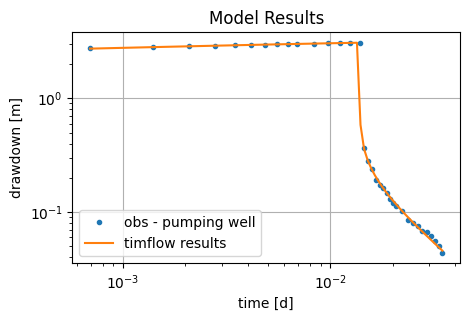

In [33]:
tm = np.logspace(np.log10(to[0]), np.log10(to[-1]), 100)
hm = w.headinside(tm)
plt.loglog(to, -ho, ".", label="obs - pumping well")
plt.loglog(tm, -hm[0], label="timflow results")
plt.xlabel("time [d]")
plt.ylabel("drawdown [m]")
plt.legend()
plt.title("Model Results")
plt.grid()

### Comparison of results

The performance of `timflow` was evaluated by comparison with MLU (Carlson and Randall, 2012). The MLU parameters are higher than the ones in `timflow`. 

In [29]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "res", "RMSE [m]"],
    index=["timflow", "MLU"],
)

t.loc["timflow"] = np.append(cal.parameters["optimal"].values, cal.rmse())
t.loc["MLU"] = [51.530, 8.16e-04, 0.022, 0.00756]

t_formatted = t.style.format(
    {"k [m/d]": "{:.2f}", "Ss [1/m]": "{:.2e}", "res": "{:.2f}", "RMSE [m]": "{:.3f}"}
)
t_formatted

,k [m/d],Ss [1/m],res,RMSE [m]
timflow,44.53,6.39e-06,0.02,0.006
MLU,51.53,8.16e-04,0.02,0.008


## References

* Carlson F. and Randall J. (2012), MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems, Ground Water 50(4):504–510
* Duffield, G.M. (2007), AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Newville, M., Stensitzki, T., Allen, D.B. and Ingargiola, A. (2014), LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python, https://dx.doi.org/10.5281/zenodo.11813, https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).